In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib.ticker import PercentFormatter
from matplotlib import colors
import matplotlib
from scipy.signal import find_peaks
import os

In [2]:
global PATH  

In [3]:
def refer_to_fat(input_img, cut_1, cut_2, cut_3):
    peaks1, _ = find_peaks(input_img[cut_1], height=0)
    peaks2, _ = find_peaks(input_img[cut_2], height=0)
    peaks3, _ = find_peaks(input_img[cut_3], height=0)
    fat_array = [peaks1[0],peaks1[-1], peaks2[0],peaks2[-1],peaks3[0],peaks3[-1]] #store all the peaks
    fat_array = [i for i in fat_array if i!=0]
    fat_array.remove(max(fat_array))
    fat_array.remove(min(fat_array))

    input_img = input_img/np.mean(fat_array)
#     print(np.mean(fat_array))
    return np.array(input_img)

In [4]:
def store_region(img_ROI, img_VIF, ROI_center, VIF_center, ROI_radius, VIF_radius):
    ROI = []
    VIF = []
    for i in range(0,144):
        for j in range(0,144):
            if (i-ROI_center[0])**2+(j-ROI_center[1])**2<=ROI_radius**2:
                if img_ROI[i][j] == 0:
                    tmp = img_ROI[i-3:i+2,j-3:j+3]
                    ROI.append(np.mean(tmp[tmp!=0])+1e-10)
                else:
                    ROI.append(img_ROI[i][j])
            if (i-VIF_center[0])**2+(j-VIF_center[1])**2<=VIF_radius**2:
                if img_VIF[i][j] == 0:
                    tmp = img_VIF[i-3:i+2,j-3:j+3]
                    VIF.append(np.mean(tmp[tmp!=0])+1e-10)
                else: 
                    VIF.append(img_VIF[i][j])
                
    return np.array(ROI), np.array(VIF)

In [5]:
def concerntration_in_tissue(start_cut, end_cut, center, radius,cut_1,cut_2,cut_3,ROI):
#     print('===ROI===')
#     print(ROI)# 1409, 1473
    c_t = []
    for file_name in range(start_cut, end_cut):
        file = pydicom.read_file(PATH+str(file_name))
        img = file.pixel_array
        img = refer_to_fat(img,cut_1,cut_2,cut_3)
        ROI_t = []
        
        for i in range(0,144):
            for j in range(0,144):
                if (i-center[0])**2+(j-center[1])**2<=radius**2:
                    if img[i][j] == 0:
                        tmp = img[i-3:i+2,j-3:j+3]
                        ROI_t.append(np.mean(tmp[tmp!=0])+1e-10)
                    else:
                        ROI_t.append(img[i][j])
        ROI_t = np.array(ROI_t)
#         print('===ROIt===')
#         print(str(file_name))
#         print(ROI_t)
        
        c_t_tmp = np.zeros(len(ROI_t))
        for i in range(len(c_t_tmp)):
            if (ROI_t[i] == 0) & (ROI[i] == 0):
                c_t_tmp[i] = 0
            else:
                c_t_tmp[i] = -np.log(ROI_t[i]/ROI[i])
    
        c_t.append(c_t_tmp)
    return np.array(c_t)  

In [6]:
def concerntration_in_plassma(start_cut, end_cut, center, radius, cut_1,cut_2,cut_3,VIF, ROI_size): # 769, 833
    c_p = []
    for file_name in range(start_cut,end_cut):
        file = pydicom.read_file(PATH+str(file_name))
        img = file.pixel_array
        img = refer_to_fat(img,cut_1,cut_2,cut_3)
#         print('DONE_concerntration_in_plassma')
       
        VIF_t = []
        for i in range(0,144):
            for j in range(0,144):
                if (i-center[0])**2+(j-center[1])**2<=radius**2:
                    if img[i][j] == 0:
                        tmp = img[i-3:i+2,j-3:j+3]
                        VIF_t.append(np.mean(tmp[tmp!=0])+1e-10)
                    else:
                        VIF_t.append(img[i][j])
        VIF_t = np.array(VIF_t)
    #     print(VIF_t)
        c_p_tmp = np.zeros(len(VIF_t))
        for i in range(len(c_p_tmp)):
            if (VIF_t[i] == 0) & (VIF[i] == 0):
                c_p_tmp[i] = 0
            else:
                c_p_tmp[i] = -np.log(VIF_t[i]/VIF[i])
    #     c_p_tmp = -np.log(VIF_t/VIF)

        c_p.append([np.mean(c_p_tmp) for i in range(ROI_size)])
    return np.array(c_p)

In [7]:
def compute_K_i(ROI, c_p, abbandon_list, y):
    Ki = []
    for i in range(len(ROI)):
        c_p_tmp = c_p[:,i]
        per_time = 0
        y_t = []
        x_t = []
        for time in range(len(c_p_tmp)):
            if time not in abbandon_list: 
                if time <= 16: 
                    per_time += c_p_tmp[time]*(4/60)
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]+1e-10))
                elif (time>16)&(time<=35):
                    per_time += c_p_tmp[time]*(6/60)
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]+1e-10))
                elif (time>35)&(time<=41):
                    per_time += c_p_tmp[time]*(8/60)
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]+1e-10))
                elif (time>41):
                    per_time += c_p_tmp[time]
                    y_t.append(y[:,i][time])
                    x_t.append(per_time/(c_p_tmp[time]+1e-10))
        x_t = np.array(x_t)
        y_t = np.array(y_t)

        y_t_mean = np.mean(y_t)
        y_t_std = np.std(y_t)

        drop_index = []
        for index in range(len(y_t)):
            if abs(y_t[index]-y_t_mean)>y_t_std:
                drop_index.append(index)

        y_t = np.delete(y_t, drop_index)
        x_t = np.delete(x_t, drop_index)

        regr = linear_model.LinearRegression()
        regr.fit(x_t.reshape(-1,1), y_t.reshape(-1,1))
        Ki.append(round(regr.coef_[0][0],5))
    return np.array(Ki)


In [8]:
def substract_Ki(Ki, bin_num):
    plt.clf()
    plot1 = np.histogram(Ki[Ki>=0], bin_num)
    plot2 = np.histogram(-1*Ki[Ki<0], plot1[1])
    bar1 = plot1[0]
    bar2 = plot2[0]
    substr_bar = np.zeros(len(bar1))
    for i in range(len(bar1)):
        if bar1[i]-bar2[i] < 0:
            substr_bar[i] = 0
        else:
            substr_bar[i] = bar1[i]-bar2[i]
    return [substr_bar/len(Ki), plot1[1],bar1/len(Ki),bar2/len(Ki)]


In [9]:
def main(PATH, start_ROI, start_VIF, center_ROI, center_VIF, radius_ROI, radius_VIF, cut_1, cut_2, cut_3,bins):
    init_ROI = pydicom.read_file(PATH+str(start_ROI))
    pixel_ROI = init_ROI.pixel_array
    
    init_VIF = pydicom.read_file(PATH+str(start_VIF))
    pixel_VIF = init_VIF.pixel_array
    
    pixel_VIF = refer_to_fat(pixel_VIF,cut_1, cut_2, cut_3)
    pixel_ROI = refer_to_fat(pixel_ROI,cut_1, cut_2, cut_3)
    
    ROI, VIF = store_region(pixel_ROI, pixel_VIF, center_ROI, center_VIF, radius_ROI, radius_VIF)
#     print(ROI)
    c_t = concerntration_in_tissue(start_ROI,start_ROI+64,center_ROI,radius_ROI, cut_1, cut_2, cut_3, ROI)
#     print(len(c_t))
#     print(len(c_t[0]))
    ROI_size = len(ROI)
    c_p = concerntration_in_plassma(start_VIF,start_VIF+64,center_VIF,radius_VIF, cut_1, cut_2, cut_3, VIF, ROI_size)
#     print(len(c_p))
#     print(len(c_p[0]))
    y = (c_t+1e-10)/(c_p+1e-10)
#     print(y)
    drop_list = [10,11,13,17,27,34,37,44,46,50,54,56,59]
    Ki = compute_K_i(ROI, c_p, drop_list, y)
    sub = substract_Ki(Ki,bins)
    return [sub[0], sub[1], sub[2], sub[3]]

In [19]:
PATH = "D:\\Brain_PR\\00936343Nov\\"
ROI_center_list = [[57,61],[58,61]]
VIF_center_list = [[55,63],[54,63]]
cut = [[70,85,90],
        [75,80,90],
        [74,87,95],
        ]
substract_arr = []
positive = []
negetive = []
for R_cen in ROI_center_list:
    for V_cen in VIF_center_list:
        for cut_row in cut:
            result = main(PATH, 1409, 769, R_cen,V_cen, 8, 8,cut_row[0], cut_row[1], cut_row[2],200)
            substract_arr.append(result[0])
            positive.append(result[2])
            negetive.append(result[3])


array([0.00465313, 0.00296108, 0.00338409, 0.00169205, 0.00296108,
       0.00549915, 0.00465313, 0.00465313, 0.00676819, 0.00211506,
       0.00338409, 0.00380711, 0.00126904, 0.00169205, 0.00253807,
       0.00549915, 0.00549915, 0.00253807, 0.00592217, 0.00211506,
       0.00338409, 0.00423012, 0.00465313, 0.00380711, 0.00380711,
       0.00253807, 0.00380711, 0.00296108, 0.00380711, 0.0071912 ,
       0.00549915, 0.00423012, 0.00465313, 0.00507614, 0.00211506,
       0.00338409, 0.00296108, 0.00507614, 0.00423012, 0.00296108,
       0.00423012, 0.00423012, 0.00169205, 0.00465313, 0.00169205,
       0.00338409, 0.00296108, 0.00211506, 0.00253807, 0.00253807,
       0.00253807, 0.00296108, 0.00211506, 0.00338409, 0.00465313,
       0.00253807, 0.00380711, 0.00253807, 0.00211506, 0.00296108,
       0.00253807, 0.00211506, 0.00296108, 0.00338409, 0.00169205,
       0.00253807, 0.00126904, 0.00211506, 0.00211506, 0.00380711,
       0.00169205, 0.00126904, 0.00126904, 0.00211506, 0.00211

200


Text(0,0.5,'fraction of voxels')

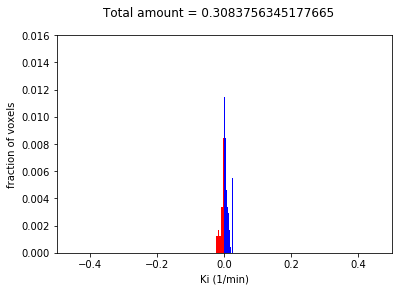

In [20]:
bins = main(PATH, 961, 897,[57,61],[55,63], 8,8, 70,85,90,200)[1][0:-1]
print(len(bins))
# bins = main(PATH, 1409, 769, [57,61],[55,63], 8, 8, 70,85,90,200)[1][0:-1]
plt.clf()
plt.bar(bins,np.mean(substract_arr, axis=0),width = 0.002,color = 'grey')

plt.xlim(-0.1, 0.1)
plt.ylim(0, 0.025)
plt.suptitle('Total amount = '+ str(np.sum(np.mean(substract_arr, axis=0))))
plt.xlabel('Ki (1/min)')
plt.ylabel('fraction of voxels')
# plt.savefig('00936343Nov after subtraction.png')

plt.clf()
plt.bar(-1*bins,np.mean(negetive, axis=0),width = 0.002,color = 'r')
plt.bar(bins,np.mean(positive, axis=0),width = 0.002,color = 'b')
plt.xlim(-0.5, 0.5)
#             plt.ylim(0, 0.5)
plt.suptitle('Total amount = '+str(np.sum(np.mean(substract_arr, axis=0))))
plt.xlabel('Ki (1/min)')
plt.ylabel('fraction of voxels')
# plt.savefig('00936343Nov before subtraction.png')

In [21]:
bins = main(PATH, 961, 897, [57,61],[55,63], 8, 8, 70,85,90,200)[1][0:-1]
print(len(bins))

200


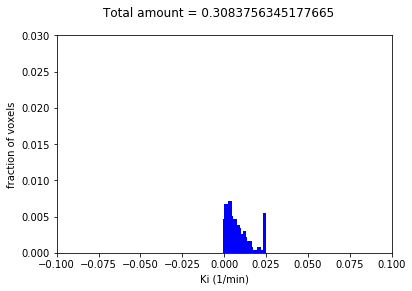

In [22]:
plt.clf()
# plt.bar(-1*bins,np.mean(negetive, axis=0),width = 0.002,color = 'r')
plt.bar(bins,np.mean(substract_arr, axis=0),width = 0.002,color = 'b')
plt.xlim(-0.1, 0.1)
plt.ylim(0, 0.03)
plt.suptitle('Total amount = '+str(np.sum(np.mean(substract_arr, axis=0))))
plt.xlabel('Ki (1/min)')
plt.ylabel('fraction of voxels')
plt.show()

In [ ]:
print(len(np.mean(substract_arr, axis=0)))

In [ ]:
# plt.clf()
# plt.bar(bins,np.mean(substract_arr, axis=0),width = 0.002,color = 'grey')
# # plt.bar(-1*bins,np.mean(negetive, axis=0),width = 0.002,color = 'r')
# # plt.bar(bins,np.mean(positive, axis=0),width = 0.002,color = 'b')
# # plt.xticks(new_ticks)
# # plt.hist(Ki, 800,rwidth=0.6)
# plt.xlim(-0.3, 0.3)
# # plt.suptitle('negetive')
# plt.xlabel('Ki (1/min)')
# plt.ylabel('fraction of voxels')
# # plt.show()
# plt.savefig('00936343June after subtraction.png')

In [ ]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
a

In [ ]:
a[1:3,0:2]

In [ ]:
np.log(10)